In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 4
IMAGE_SIZE = 331
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Sugarcane Leaf Image Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6748 files belonging to 11 classes.


In [4]:
class_names = dataset.class_names
class_names

['Banded Chlorosis',
 'Brown Spot',
 'BrownRust',
 'Dried Leaves',
 'Grassy shoot',
 'Healthy Leaves',
 'Pokkah Boeng',
 'Sett Rot',
 'Viral Disease',
 'Yellow Leaf',
 'smut']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(4, 331, 331, 3)
[ 1  6  1 10]


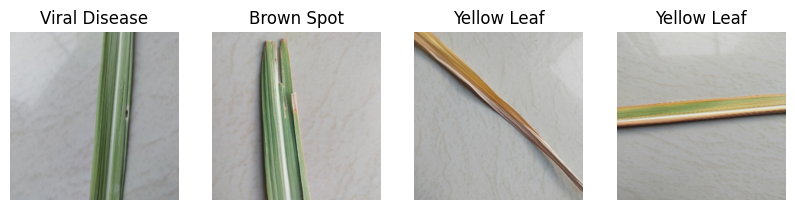

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)


1687

In [9]:
train_size = 0.8
len(dataset)*train_size

1349.6000000000001

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

1633

In [12]:
val_size=0.1
len(dataset)*val_size

168.70000000000002

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

1627

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [17]:
len(train_ds)


1349

In [18]:
len(test_ds)

170

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
from keras.applications.nasnet import NASNetLarge
# from keras.applications.resnet50 import preprocess_input,decode_predictions
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten
from keras.models import Model
from keras.utils import to_categorical

In [24]:
nasnet=NASNetLarge(include_top=True,weights='imagenet')


In [25]:
import tensorflow as tf


In [26]:
x=nasnet.layers[-2].output
fc1=Dense(6, kernel_regularizer=tf.keras.regularizers.l2(0.02),activation='softmax')(x)

In [27]:
model=Model(inputs=nasnet.input,outputs=fc1)


In [28]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                             

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


NotFoundError: Graph execution error:

Detected at node 'model/separable_conv_1_normal_right1_0/separable_conv2d' defined at (most recent call last):
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Jerico\anaconda3\envs\useGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Jerico\AppData\Local\Temp\ipykernel_24004\1320925133.py", line 1, in <module>
      history = model.fit(
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Jerico\AppData\Roaming\Python\Python38\site-packages\keras\layers\convolutional\separable_conv2d.py", line 180, in call
      outputs = tf.compat.v1.nn.separable_conv2d(
Node: 'model/separable_conv_1_normal_right1_0/separable_conv2d'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 21518848 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 21518848 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 993343744 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 993343744 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 35969536 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 35969536 bytes.
	 [[{{node model/separable_conv_1_normal_right1_0/separable_conv2d}}]] [Op:__inference_train_function_69008]